In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
import scikit_posthocs as sp
from scipy.stats import kruskal
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_columns', None)  # Отображение всех столбцов
# pd.set_option('display.max_rows', None)  # Ото----бражение всех строк   

In [2]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')



volunteers = volunteers[volunteers.athlete_age < 100]
starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 5000]

starts['rain.1h'] = starts['rain.1h'].fillna(0)
starts['snow.1h'] = starts['snow.1h'].fillna(0)

cnt_ludei = starts.groupby(['event_name', 'event_date', 'region']).agg(
    cnt_runners = ('athlete_id', 'count')
)


young_volunteers = volunteers[volunteers['athlete_age'] <= 14]

starts = starts.merge(young_volunteers[['event_name', 'event_date', 'athlete_id']], 
                      on=['event_name', 'event_date'], 
                        how='left',
                      suffixes=('', '_vol'))

starts['has_young_volunteers'] = starts['athlete_id_vol'].notna()
starts['has_young_volunteers'] =starts['has_young_volunteers'].astype(int)
starts = starts.drop(columns=['athlete_id_vol'], axis=1)





ages_14 = starts[starts['athlete_age'] == 14]['athlete_id'].unique()
ages_15 = starts[starts['athlete_age'] == 15]['athlete_id'].unique()
common_athletes = set(ages_14) & set(ages_15)
starts = starts[~starts['athlete_id'].isin(common_athletes)]



starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])   # удаление где 0 волонтеров в сумме было


unique_dates = (
    pd.concat([
        starts[['athlete_id', 'event_date']],
        volunteers[['athlete_id', 'event_date']]
    ])
    .drop_duplicates()
)
date_counts = unique_dates.groupby('athlete_id').size().reset_index(name='unique_event_count')
date_counts['is_repeated'] = (date_counts['unique_event_count'] > 1).astype(int)
starts = starts.merge(date_counts[['athlete_id', 'is_repeated']], on='athlete_id', how='left')


# starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  
starts = starts[starts.event_date <= '2023-10-15']


newbie = starts[starts['is_newbie'] == 1]
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = first_runs[first_runs.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
come_with_didnt_come = come_with_didnt_come.merge(cnt_ludei,on=['event_name', 'event_date', 'region'], how="left")
print(len(come_with_didnt_come))

16708


Кластеризация по количеству участников


In [3]:
event_data = (come_with_didnt_come
              .groupby(['event_date', 'event_name'], as_index=False)
              .agg({'cnt_runners': 'mean'}))

event_data = event_data[event_data.cnt_runners < 500]

k = 3
X = event_data[['cnt_runners']]
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
event_data['cluster'] = kmeans.fit_predict(X)

cluster_stats = (event_data
                 .groupby('cluster')
                 .agg(
                     cluster_min=('cnt_runners', 'min'),
                     cluster_max=('cnt_runners', 'max'),
                     cluster_mean=('cnt_runners', 'mean')
                 )
                 .reset_index())


cluster_stats = cluster_stats.sort_values('cluster_mean')
cluster_stats['new_cluster'] = range(len(cluster_stats))


cluster_map = dict(zip(cluster_stats['cluster'], cluster_stats['new_cluster']))


event_data['cluster'] = event_data['cluster'].map(cluster_map)


final_cluster_stats = (event_data
                       .groupby('cluster')
                       .agg(
                           cluster_min=('cnt_runners', 'min'),
                           cluster_max=('cnt_runners', 'max'),
                           cluster_mean=('cnt_runners', 'mean')
                       )
                       .reset_index()
                       .sort_values('cluster'))


print("Интервалы кластеров по cnt_runners:")
for i, row in final_cluster_stats.iterrows():
    print(f"Кластер {int(row['cluster'])}: от {row['cluster_min']} до {row['cluster_max']} участников (среднее {row['cluster_mean']:.2f})")

if 'cluster' in come_with_didnt_come.columns:
    come_with_didnt_come = come_with_didnt_come.drop(columns=['cluster'])

come_with_didnt_come = come_with_didnt_come.merge(
    event_data[['event_date', 'event_name', 'cluster']],
    on=['event_date', 'event_name'],
    how='left'
)



cluster_counts = come_with_didnt_come.groupby('cluster').size().reset_index(name='count')
print("\n Число наблюдений (участников) в каждом кластере:")
print(cluster_counts)


Интервалы кластеров по cnt_runners:
Кластер 0: от 2.0 до 45.0 участников (среднее 24.73)
Кластер 1: от 46.0 до 138.0 участников (среднее 66.75)
Кластер 2: от 140.0 до 404.0 участников (среднее 209.65)

 Число наблюдений (участников) в каждом кластере:
   cluster  count
0      0.0   7990
1      1.0   5959
2      2.0   1865


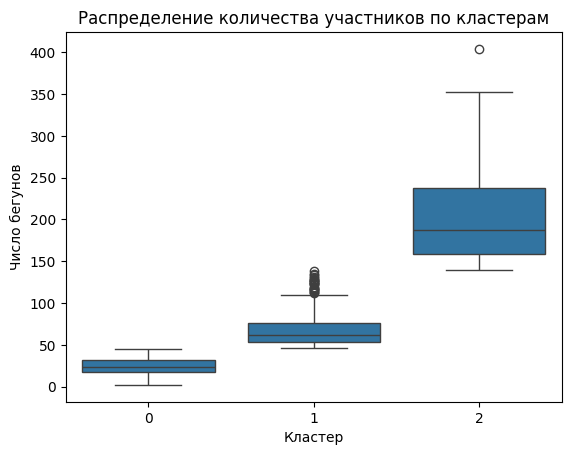

In [4]:
sns.boxplot(x='cluster', y='cnt_runners', data=event_data)
plt.title("Распределение количества участников по кластерам")
plt.ylabel('Число бегунов')
plt.xlabel('Кластер')
plt.show()

Проведем тест критерием Краскелла-Уоллиса, а также тест Данна для попарных сравнений кластеров

In [5]:
import pandas as pd


groups = [event_data.loc[event_data['cluster'] == c, 'cnt_runners'] for c in range(k)]
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis test: H-statistic =", stat, ", p-value =", p_value)


if p_value < 0.05:
    posthoc = sp.posthoc_dunn([event_data.loc[event_data['cluster'] == c , 'cnt_runners'] for c in range(k)], val_col='value', group_col='group', p_adjust='bonferroni')
    print("Результат пост-хок анализа (тест Данна):")
    print(posthoc)
else:
    print("Нет статистически значимых различий между группами (по тесту Краскала-Уоллиса).")


Kruskal-Wallis test: H-statistic = 1838.8070675620077 , p-value = 0.0
Результат пост-хок анализа (тест Данна):
              1         2             3
1  1.000000e+00  0.000000  1.744476e-47
2  0.000000e+00  1.000000  1.683432e-02
3  1.744476e-47  0.016834  1.000000e+00


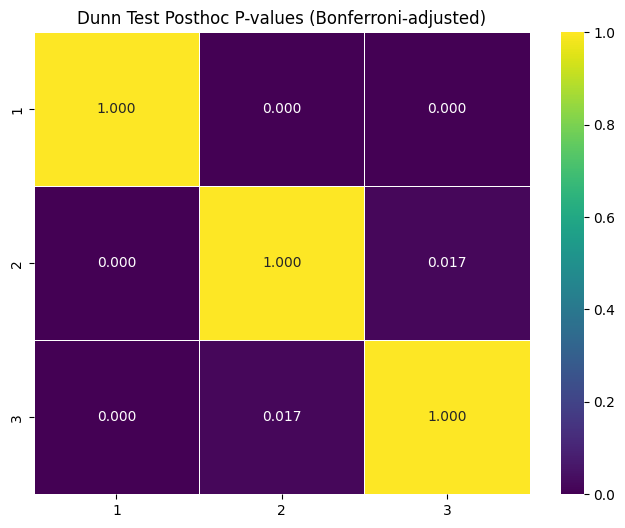

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(posthoc, annot=True, cmap='viridis', linewidths=0.5, fmt=".3f")
plt.title("Dunn Test Posthoc P-values (Bonferroni-adjusted)")
plt.show()


Все кластеры различаются статзначимо


# 0. Корреляции с is_repeated

In [78]:
numeric_cor = come_with_didnt_come.select_dtypes(include=['number'])
print(numeric_cor.corr(method='spearman')['is_repeated'].sort_values(ascending=False))

is_repeated                          1.000000
athlete_age                          0.104506
is_male                              0.035946
wind_speed                           0.031991
wind_deg                             0.030570
snow.1h                              0.018583
Составление отчёта                   0.012926
Пейсер                               0.012401
Координатор парковки                 0.008598
Сурдопереводчик                      0.005589
Организация финиша                   0.003767
Лидер для слабовидящих               0.000608
Раздача карточек позиций            -0.012038
pressure                            -0.017352
temp                                -0.018790
clouds                              -0.021863
feels_like                          -0.023001
Подготовка мероприятия              -0.024240
humidity                            -0.030813
Проведение разминки                 -0.032564
Инструктаж новых участников         -0.035377
Ведущий велосипед                 

In [79]:
display(come_with_didnt_come.head(2))

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,has_young_volunteers,is_male,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers,cnt_runners,cluster
0,4827,790126879,Мещерский,2023-01-01,Одинцово,Московская область,2029,женский,38,1,0.85,-3.85,1007,100,0.85,100,5.0,200,Drizzle,light intensity drizzle,0.0,0.0,"гранитная крошка, грунт",1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,1,14.0,42,0.0
1,4831,790087643,Губайловский Экопарк,2023-01-01,Красногорск,Московская область,1509,мужской,15,1,0.65,-4.63,1006,100,0.65,100,6.0,200,Clouds,overcast clouds,0.0,0.0,асфальт,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,7.0,31,0.0


# 1.0. Общий катбуст для кол-ва волонтеров

In [21]:
from catboost import CatBoostClassifier, Pool  
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_newbie',  'is_newbie',
   # 'athlete_gender', 'weather.main','weather.description','track_description_surface',
 #   'dew_point',
    'is_male',
    'cnt_volunteers',
    #'humidity','finish_time', 'athlete_age', 'athlete_gender', 'wind_speed', 'feels_like', 
    #'pressure', 'temp', 
    # 'snow.1h', 'rain.1h', 'weather.main', 'weather.description', 'track_description_surface', 'wind_deg', 'clouds', 
    #'cnt_runners'
], axis=1)  
y = come_with_didnt_come['is_repeated']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
categorical_cols = ['athlete_gender', 'weather.main', 'weather.description', 'track_description_surface']

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1,verbose=0  ,cat_features=categorical_cols)  
print('катбуст начальный со всеми переменными')
model.fit(X_train, y_train)  


preds = model.predict(X_test)  
cm = confusion_matrix(y_test, preds)
print(cm)
print(f'Accuracy: {accuracy_score(y_test, preds):.2f}') 




feature_importances = model.get_feature_importance()  
importance_df = pd.DataFrame({  
    'Feature': X.columns,  # Используйте реальные имена признаков  
    'Importance': feature_importances  
})  

# Сортировка значений важности в порядке убывания  
importance_df = importance_df.sort_values(by='Importance', ascending=False)  

display(importance_df)


катбуст начальный со всеми переменными
[[ 704  826]
 [ 432 1380]]
Accuracy: 0.62


,Feature,Importance
2,athlete_age,11.271321
0,finish_time,10.552351
44,cnt_runners,10.490960
9,wind_speed,6.473434
7,dew_point,5.861125
10,wind_deg,5.234646
5,pressure,5.078937
3,temp,4.804589
6,humidity,3.663715
4,feels_like,3.424572


# 1.1. Общий катбуст для has_volunteer и корреляции с is_repeated и has_volunteer

In [22]:
volunteer_columns = come_with_didnt_come.columns[25:52]  

# Создаем новый DataFrame для хранения результатов  
has_volunt = come_with_didnt_come.copy()  

# Перебираем роли волонтеров  
for column in volunteer_columns:  
    role_name = str(column) # Извлекаем имя роли  
    new_column_name = f'has_{role_name}'  # Создаем новое название колонки  
    has_volunt[new_column_name] = (come_with_didnt_come[column] > 0).astype(int)  # Устанавливаем 1, если есть волонтеры этой роли, иначе 0  

# Удаляем старые колонки с ролями, если требуется  
has_volunt = has_volunt.drop(columns=volunteer_columns)  
has_volunt_numeric = has_volunt.select_dtypes(include=['number'])
display(has_volunt_numeric.corr(method='spearman')['is_repeated'].sort_values(ascending=False))

is_repeated                              1.000000
rain.1h                                  0.186055
athlete_age                              0.104506
is_male                                  0.035946
wind_speed                               0.031991
wind_deg                                 0.030570
has_Пейсер                               0.013480
has_Составление отчёта                   0.012949
has_Координатор парковки                 0.008598
has_Проведение разминки                  0.007960
has_Сурдопереводчик                      0.005589
has_Организация финиша                   0.004868
has_Лидер для слабовидящих               0.000556
has_Замыкающий                          -0.011619
has_Организатор                         -0.014955
pressure                                -0.017352
has_Раздача карточек позиций            -0.018588
temp                                    -0.018790
has_Сканирование штрих-кодов            -0.020241
has_Секундомер                          -0.021316


In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



lower_bound, upper_bound = 0, 500
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= lower_bound) & (come_with_didnt_come.cnt_runners <= upper_bound)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= lower_bound) & (come_with_didnt_come.cnt_runners <= upper_bound)]
X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 
                                       'is_newbie', 'athlete_gender', 'weather.main','weather.description', 'cluster', 'track_description_surface', 
                                       'cnt_volunteers'], axis=1)   
y = come_with_didnt_come['is_repeated']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0, task_type='GPU')
model.fit(X_train, y_train)
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)
print("Для всех участников:")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")

# Получаем начальные важности
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
display(importance_df)




Для всех участников:
Confusion Matrix:
 [[ 681  849]
 [ 409 1403]]
Accuracy: 0.62


,Feature,Importance
41,cnt_runners,14.396262
1,athlete_age,11.568673
35,Сканирование штрих-кодов,8.365733
0,finish_time,7.806970
6,dew_point,7.607851
8,wind_speed,5.245439
4,pressure,4.962633
7,clouds,4.258027
5,humidity,4.220492
9,wind_deg,4.196911


Сделаем катбуст с RFE

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

lower_bound, upper_bound = 0, 500
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= lower_bound) & (come_with_didnt_come.cnt_runners <= upper_bound)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= lower_bound) & (come_with_didnt_come.cnt_runners <= upper_bound)]
X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 
                                       'is_newbie', 'athlete_gender', 'weather.main', 'dew_point', 'temp','weather.description', 'cluster', 'track_description_surface', 
                                       'cnt_volunteers'], axis=1)   
y = come_with_didnt_come['is_repeated']   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0, task_type='GPU')
rfe = RFE(model, n_features_to_select=20)
rfe.fit(X, y)
print("Выбранные признаки:", X.columns[rfe.support_])

preds = rfe.predict(X_test)
cm = confusion_matrix(y_test, preds)
print("Для всех участников:")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")

Выбранные признаки: Index(['finish_time', 'athlete_age', 'temp', 'feels_like', 'pressure',
       'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'rain.1h',
       'snow.1h', 'Маршал', 'Связи с общественностью', 'Секундомер',
       'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф',
       'Хранение и доставка оборудования', 'cnt_runners'],
      dtype='object')
Для всех участников:
Confusion Matrix:
 [[ 752  778]
 [ 305 1507]]
Accuracy: 0.68


Оценка catboost бутстрапом

In [34]:
# Теперь сделаем бутстрап оценку
n_bootstrap = 50  # Количество бутстрап-итераций (можно увеличить для большей точности)
np.random.seed(42)

features = X.columns
bootstrap_importances = np.zeros((n_bootstrap, len(features)))

for i in range(n_bootstrap):
    # Генерируем bootstrap-выборку индексов
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_boot = X_train.iloc[bootstrap_indices]
    y_boot = y_train.iloc[bootstrap_indices]

    # Обучаем модель на бутстрап-выборке
    model_boot = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1, verbose=0)
    model_boot.fit(X_boot, y_boot)

    # Получаем важности признаков на бутстрап-выборке
    fi = model_boot.get_feature_importance(Pool(X_boot, y_boot))
    bootstrap_importances[i, :] = fi

# Теперь у нас есть матрица bootstrap_importances размером [n_bootstrap, кол-во признаков],
# где каждая строка — это вектор важностей из одного bootstrap-повтора.

# Рассчитаем среднее, стандартное отклонение и доверительные интервалы для важностей
mean_importances = bootstrap_importances.mean(axis=0)
std_importances = bootstrap_importances.std(axis=0)

# 95% доверительный интервал (можно изменить уровень)
alpha = 0.05
lower_bound = np.percentile(bootstrap_importances, 100*alpha/2, axis=0)
upper_bound = np.percentile(bootstrap_importances, 100*(1 - alpha/2), axis=0)

bootstrap_results = pd.DataFrame({
    'Feature': features,
    'Mean_Importance': mean_importances,
    'Std_Importance': std_importances,
    'CI_lower': lower_bound,
    'CI_upper': upper_bound
}).sort_values(by='Mean_Importance', ascending=False)

display(bootstrap_results)

# Интерпретация:
# Если доверительный интервал для важности признака не включает нулевые значения (или около нуля),
# можно говорить о том, что этот признак стабильно вносит вклад в модель.
# Это не "p-value" в строгом смысле, но дает понимание устойчивости важности.

,Feature,Mean_Importance,Std_Importance,CI_lower,CI_upper
0,finish_time,14.845460,0.575611,13.851435,16.018328
1,athlete_age,12.268604,0.541023,11.088610,13.038101
41,cnt_runners,7.118962,0.764954,5.730460,8.441428
8,wind_speed,6.334691,0.512589,5.526233,7.486300
9,wind_deg,5.799568,0.478686,4.811048,6.771900
6,dew_point,5.689034,0.490519,4.837705,6.634113
4,pressure,5.476953,0.584433,4.257483,6.412572
2,temp,4.641136,0.495955,3.657917,5.501958
5,humidity,4.635736,0.424561,3.807246,5.397531
3,feels_like,4.102461,0.552443,2.929114,5.165648


Логит для 2 -- 46 на топ-12 волонтерах из катбуста (бутстрапа)

In [83]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]



need_columns = ['finish_time', 'athlete_age',  'feels_like', 'pressure',
       'humidity', 'wind_speed', 'Маршал', 'Связи с общественностью', 'Секундомер',
       'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф',
       'Хранение и доставка оборудования', 'cnt_runners']
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

Optimization terminated successfully.
         Current function value: 0.659417
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8113
Model:                          Logit   Df Residuals:                     8098
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02555
Time:                        00:39:43   Log-Likelihood:                -5349.8
converged:                       True   LL-Null:                       -5490.1
Covariance Type:            nonrobust   LLR p-value:                 1.307e-51
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [85]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 46) & (come_with_didnt_come.cnt_runners <= 139)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 46) & (come_with_didnt_come.cnt_runners <= 139)]



need_columns = ['finish_time', 'athlete_age',  'feels_like', 'pressure',
       'humidity', 'wind_speed', 'Маршал', 'Связи с общественностью', 'Секундомер',
       'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф',
       'Хранение и доставка оборудования', 'cnt_runners']
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 46-138 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

Optimization terminated successfully.
         Current function value: 0.678642
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 46-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5959
Model:                          Logit   Df Residuals:                     5944
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.01382
Time:                        00:40:54   Log-Likelihood:                -4044.0
converged:                       True   LL-Null:                       -4100.7
Covariance Type:            nonrobust   LLR p-value:                 1.240e-17
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

In [11]:
come_with_didnt_come.columns[25:52]

Index(['Ведущий велосипед', 'Завершение мероприятия', 'Замыкающий',
       'Инструктаж новых участников', 'Координатор парковки',
       'Координация волонтёров', 'Лидер для слабовидящих', 'Маршал',
       'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер',
       'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
       'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы',
       'Раздача карточек позиций', 'Разное', 'Связи с общественностью',
       'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
       'Составление отчёта', 'Сурдопереводчик', 'Фотограф',
       'Хранение и доставка оборудования'],
      dtype='object')

In [ ]:
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 138) & (come_with_didnt_come.cnt_runners <= 404)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 138) & (come_with_didnt_come.cnt_runners <= 404)]



need_columns = ['finish_time', 'athlete_age',  'feels_like', 'pressure',
       'humidity', 'wind_speed', 'Маршал', 'Связи с общественностью', 'Секундомер',
       'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф',
       'Хранение и доставка оборудования', 'cnt_runners']
                






for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2],method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('ошибка в цикле на проверке корреляций между ', col1, " ", col2)

for_model = X[need_columns]


for_model = sm.add_constant(for_model)
y = y['is_repeated']
model = sm.Logit(y, for_model).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 46-138 людей')
print('\n')
print(model.summary())
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

y_pred = model.predict(for_model)
y_pred_class = (y_pred > 0.5).astype(int)  
cm = confusion_matrix(y, y_pred_class)
print(cm)
accuracy = (y_pred_class == y).mean()  
print(f'Accuracy: {accuracy:.2f}')  

Optimization terminated successfully.
         Current function value: 0.659766
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 46-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1904
Model:                          Logit   Df Residuals:                     1889
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.04811
Time:                        00:42:46   Log-Likelihood:                -1256.2
converged:                       True   LL-Null:                       -1319.7
Covariance Type:            nonrobust   LLR p-value:                 2.677e-20
                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

In [32]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=14)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'Завершение мероприятия', 'Инструктаж новых участников', 'Организатор', 'Пейсер', 'Раздача карточек позиций', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.658572
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8113
Model:                          Logit   Df Residuals:                     8098
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02680
Time:                        01:31:41   Log-Likelihood:                -5343.0
converged:                    

In [31]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=14)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'humidity', 'Ведущий велосипед', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Помощь в раздаче карточек позиций', 'Раздача карточек позиций', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Хранение и доставка оборудования']
Optimization terminated successfully.
         Current function value: 0.674369
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5836
Model:                          Logit   Df Residuals:                     5821
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.01990
Time:                        01:31:17   Log-Likelihood:                -3935.6
converged:

In [34]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=14)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'humidity', 'Организация финиша', 'Проверка трассы', 'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.653420
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1865
Model:                          Logit   Df Residuals:                     1850
Method:                           MLE   Df Model:                           14
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.05707
Time:                        01:35:46   Log-Likelihood:                -1218.6
converged:                     